In [70]:
import os
import pygame
import time 
import sys
import pandas as pd
import numpy as np
import shutil
from matplotlib import cm
from collections import Counter
from PIL import Image
import random

from utils import *

In [39]:
common_list = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ一三四五六'
font_file = './fonts'
image_file = 'images'
fonts = os.listdir(font_file)

print(fonts)

for font in fonts:
    try:
        font_path = os.path.join(font_file, font)
        font2image(font_path, image_file, common_list, 60)
    except:
        print(font, "failed......")
# remove_empty_floder(image_file)

['HachiMaruPop.ttf']


# testing

In [26]:
# importing image object from PIL 
from PIL import Image, ImageOps 

# creating an image object 
img = Image.open(r"images/HachiMaruPop/A+.png").convert("L") 

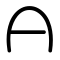

In [27]:
img

In [34]:
# image colorize function 
img_new = ImageOps.colorize(img, black ='rgb(205,200,0)', white ="white")

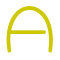

In [35]:
img_new

# from utils

In [116]:

import os
import pygame
import time 
import sys
import pandas as pd
import numpy as np
import shutil
from matplotlib import cm
from collections import Counter
from PIL import Image

pygame.init()

def font2image(input_file, output_paths, characters, size):
    input_file_name = input_file.split(os.sep)[-1].split('.')[0]   # get output file_name
    output_path = os.path.join(output_paths, input_file_name)
    
    if not os.path.exists(output_path):
        os.mkdir(output_path)
        
    AZ = [chr(i) for i in range(0x0041,0x005A+1)]    
    file_sizes=[]    
    for word in characters:
        font = pygame.font.Font(input_file, size)
        rtext = font.render(word, True, (0, 0, 0), (255, 255, 255))
        
        if word in AZ:      # for uppercase letter
            word = word+'+'
        pygame.image.save(rtext, os.path.join(output_path,word+".png"))
        
    remove_duplicated_images(output_path)
    process_image(output_path, size)
    
def remove_duplicated_images(path):
    while True:
        files = os.listdir(path)
        if len(files)==0:
            print('!!!!!!!!!!!!!!!!!!error:{}'.format(path))
            break
        file_sizes = []
        for file in files:
            file_size = os.path.getsize(os.path.join(path,file))
            file_sizes.append(file_size)
        counter = Counter(file_sizes)
        most_common_number = counter.most_common(1)[0][1]
        if most_common_number<=10:
            break
        most_common = counter.most_common(1)[0][0]
        for file in files:                                        # remove empty images
            file_path = os.path.join(path, file)
            if os.path.getsize(file_path)==most_common:
                os.remove(file_path)  
                
def load_image(path):
    image = Image.open(path).convert('L')
    image = np.array(image)
    return image

def cut_image(image):
    (h, w) = image.shape
    h_value = 255*h
    w_value = 255*w
    left = 0
    right = w
    upper = 0
    bottom = h
    for r in range(w):
        value = image[:, r].sum()
        if value==h_value:
            left += 1
        else:
            break
    for r in range(w-1, -1, -1):
        value = image[:,r].sum()
        if value==h_value:
            right -= 1
        else:
            break
    for c in range(h):
        value = image[c, :].sum()
        if value==w_value:
            upper += 1
        else:
            break
    for c in range(h-1, -1, -1):
        value = image[c, :].sum()
        if value==w_value:
            bottom -= 1
        else:
            break
    if left==w or right==0 or upper==h or bottom==0:
        left = 0
        right = w
        upper = 0
        bottom = h
    image_cut = image[upper:bottom, left:right]
    return image_cut

def resize_image(image_cut, size):
    (h, w) = image_cut.shape
    image_p = Image.fromarray(np.uint8(cm.gray(image_cut)*255))
    image_resized = image_p
    if h>w:
        if h>size:
            ratio = h/size
            adjust = int(w/ratio)
            if adjust<1:
                adjust=1
            image_resized = image_p.resize((adjust, size))
    else:
        if w>size:
            ratio = w/size
            adjust = int(h/ratio)
            if adjust<1:
                adjust=1
            image_resized = image_p.resize((size, adjust))
    return image_resized

def pad_image(image_resized, size):
    back = Image.new('L', (size, size), color=255)
    h_r, v_r = image_resized.size
    h = int((size-h_r)/2)
    v = int((size-v_r)/2)
    back.paste(image_resized,(h, v))
    return back

def color_text(image, color):
    '''
    By himanshu
    coloring the text
    '''
    return ImageOps.colorize(image, black =color, white ="white")

def get_random_color():
    
    color = 'rgb(' + str(random.randint(0, 255)) + ',' + str(random.randint(0, 255)) + ',' + str(random.randint(0, 255)) +')'
    
    return color

def process_image(path, size):
    files = os.listdir(path)
    
    color = get_random_color()
    
    for file in files:
        file_path = os.path.join(path, file)
        image = load_image(file_path)
        image = cut_image(image)
        image = resize_image(image, size)
        image = pad_image(image, size)
        image = color_text(image, color)
        image.save(file_path)
        
def remove_empty_floder(path):
    files = os.listdir(path)
    for file in files:
        if not os.listdir(os.path.join(path,file)):
            os.rmdir(os.path.join(path,file))
            print(file,' |removed')
    print("done!")
    
# check current font exists the given characters or not 
def check_image_exists(path, characters):
    AZ = [chr(i) for i in range(0x0041,0x005A+1)]  
    for word in characters:
        if word in AZ:      
            word = word+'+'
        image = word+'.png'
        image_path = os.path.join(path, image)
        if not os.path.exists(image_path):
            print('no ', word)
    print('done!')

In [118]:
common_list = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ一三四五六'
font_file = './fonts'
image_file = 'images'
fonts = os.listdir(font_file)

print(fonts)

for font in fonts:
    try:
        font_path = os.path.join(font_file, font)
        font2image(font_path, image_file, common_list, 60)
    except:
        print(font, "failed......")
# remove_empty_floder(image_file)

['HachiMaruPop.ttf']
